## Sklearn classic classification tasks
This notebook investigates the potential for a more classic approach to solving the defect detection problem for the given data-set.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, norm
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
import ast
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#Import naive bayes
from sklearn.naive_bayes import GaussianNB
#import Knn
from sklearn.neighbors import KNeighborsClassifier

#For truncated svd, we need to import the base estimator and classifier mixin
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

#Import seaborn
import seaborn as sns
import scipy

In [91]:
import torch
import torchvision.transforms as transforms

#### Loading the images and and storing them in a matrix, note we undersample the majority class

In [102]:

def load_image(path):
    img = Image.open(f'{base_dir}{path}')
    #Resize the image to 320x320
    img = img.resize((320, 320))
    img = transforms.ToTensor()(img).detach().numpy()
    img = img.flatten()
    #img = img.reshape((-1,1))
    return img

def get_images(data, M=500,train=True):
    # Load the data such that the collumns of X is the image as a vector
    # Initialize np array of size (320*320,len(data))
    X = [] #np.zeros(((320 * 320),M*2))
    y = []#[None] * (M*2)
    neg_count = 0
    pos_count = 0
    for (i, row) in tqdm(data.iterrows()):
        #label = ast.literal_eval(row['Label'])
        label = row['Label']

        if label[0] == 'Negative' and neg_count < M:
            im = load_image(row['ImageDir'])
            #X[:,i] = im
            X.append(im)
            #y[i] = -1
            y.append(-1)
            if train:
                neg_count += 1
        elif label[0] != 'Negative' and pos_count < M:
            im = load_image(row['ImageDir'])
            #X[:,i] = im
            X.append(im)
            #y[i] = 1
            y.append(1)
            if train:
                pos_count += 1
        elif neg_count >= M and pos_count >= M:
            print("What")
            break
        else:
            continue
    X = np.array(X)
    X = X.T#We want the collumns to be the images
    #X = X[:, ~np.all(X == 0, axis=0)]
    #y = [x for x in y if x is not None]
    return X, np.array(y)

## actually load the data test and train data

In [103]:
# Load the data
converters = {
    'Label': lambda x: ast.literal_eval(x),
    'MaskDir': lambda x: ast.literal_eval(x) if str(x) != 'nan' else x
}

train_data = pd.read_csv('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/TrainVitusStat.csv',converters = converters)
train_data = train_data.drop(['Unnamed: 0'], axis=1)
test_data = pd.read_csv('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/TestVitusStat.csv')
test_data = test_data.drop(['Unnamed: 0'], axis=1)
base_dir = '/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/'
# define class labels
labels = {
    0: 'Negative',
    1: 'Positive',
}
#Inverse labels
inv_labels = {v: k for k, v in labels.items()}

# Training data size
M = 60 # Number of images

In [104]:
#Create the X and y matrices
X_train,y_train = get_images(train_data,train=True)
X_test,y_test = get_images(test_data,train=False)

18102it [00:03, 5512.54it/s] 


What


7210it [00:19, 371.36it/s]


In [105]:
X_train.mean(),X_train.std()

(0.513663, 0.15579082)

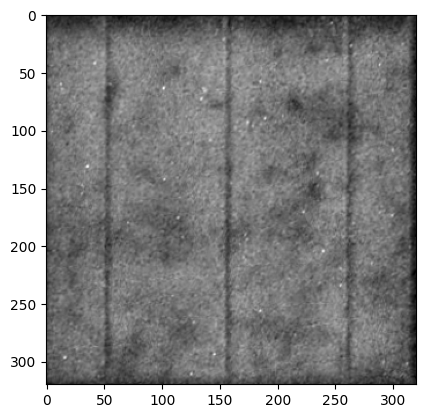

In [117]:
t = transforms.Normalize((0.513663), (0.15579082))
im = torch.tensor(X_train[:,0].reshape(320,320)[None,:,:])
im = t(im)
plt.imshow(im[0,:,:],cmap = 'gray')

## MCNemars Test

In [54]:
def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    # perform McNemars test
    nn = np.zeros((2,2))
    c1 = yhatA - y_true == 0
    c2 = yhatB - y_true == 0

    nn[0,0] = sum(c1 & c2)
    nn[0,1] = sum(c1 & ~c2)
    nn[1,0] = sum(~c1 & c2)
    nn[1,1] = sum(~c1 & ~c2)

    n = sum(nn.flat);
    n12 = nn[0,1]
    n21 = nn[1,0]

    thetahat = (n12-n21)/n
    Etheta = thetahat

    Q = n**2 * (n+1) * (Etheta+1) * (1-Etheta) / ( (n*(n12+n21) - (n12-n21)**2) )

    p = (Etheta + 1)*0.5 * (Q-1)
    q = (1-Etheta)*0.5 * (Q-1)

    CI = tuple(lm * 2 - 1 for lm in scipy.stats.beta.interval(1-alpha, a=p, b=q) )

    p = 2*scipy.stats.binom.cdf(min([n12,n21]), n=n12+n21, p=0.5)
    print("Result of McNemars test using alpha=", alpha)
    print("Comparison matrix n")
    print(nn)
    if n12+n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=",(n12+n21))

    print("Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = ", CI)
    print("p-value for two-sided test A and B have same accuracy (exact binomial test): p=", p)

    return thetahat, CI, p

In [55]:
mcnemar(y_test,y_pred_ada,y_pred_svd)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[3283. 1305.]
 [1360. 1262.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.021658676799120702, 0.006403570065950603)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.2955446401906925


(-0.0076282940360610264,
 (-0.021658676799120702, 0.006403570065950603),
 0.2955446401906925)

#### Now try with the HistGradientBoosting ensemble method
Add the scaler and ensemble method to a pipeline

In [6]:
#Scale the data
scaler = StandardScaler()

#Make pipeline
hgb_pipe = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())
parameters = {
 'histgradientboostingclassifier__max_iter': [1000,1200,1500],
 'histgradientboostingclassifier__learning_rate': [0.1],
 'histgradientboostingclassifier__max_depth' : [25, 50, 75],
 'histgradientboostingclassifier__l2_regularization': [1.5],
 'histgradientboostingclassifier__scoring': ['f1_micro'],
 'histgradientboostingclassifier__random_state' : [42],
 }

#hgb_grid = GridSearchCV(hgb_pipe, parameters, n_jobs=5, cv=5, scoring='f1_micro', verbose=2, refit=True)

hgb_pipe.fit(X_train.T, y_train)

#Make classification report
y_pred = hgb_pipe.predict(X_test.T)

#Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.99      0.70      0.82      7108
           1       0.03      0.65      0.06       102

    accuracy                           0.70      7210
   macro avg       0.51      0.68      0.44      7210
weighted avg       0.98      0.70      0.81      7210



In [ ]:
#Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())
disp.plot()
plt.show()

### Testing a bunch of different algorithms 

First test the 1-layer nn, which utilises truncated svd to classify the images, note that I made it such that it acts like an sklearn classifier.  

In [46]:
#Write class for truncated SVD such that it acts like an sklearn classifier
class TruncatedSVDClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,inverter='pinv'):
        self.inverter = inverter

    def fit(self, X, y):
        X_pinv = np.linalg.pinv(X_train)
        A = np.matmul(y_train, X_pinv)
        self.A = A
        return self

    def predict(self, X):
        y_pred = np.matmul(self.A, X)
        return np.sign(y_pred)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y_pred == y)/len(y)

In [47]:
clf = TruncatedSVDClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.99      0.64      0.78      7010
    Positive       0.05      0.67      0.09       200

    accuracy                           0.64      7210
   macro avg       0.52      0.66      0.44      7210
weighted avg       0.96      0.64      0.76      7210



In [49]:
y_pred_svd = y_pred

In [51]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.99      0.64      0.78      7010
    Positive       0.05      0.67      0.09       200

    accuracy                           0.64      7210
   macro avg       0.52      0.66      0.44      7210
weighted avg       0.96      0.64      0.76      7210



Text(0.5, 1.0, 'Truncated SVD')

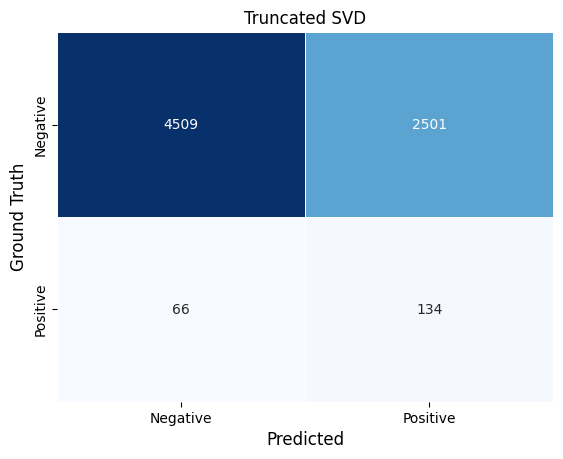

In [31]:
cm = confusion_matrix(y_test,y_pred)
fig1,ax1 = plt.subplots(1)
sns.heatmap(cm,
            annot=True,
            ax = ax1,
            linewidth=.5,
            fmt='g',
            cmap = 'Blues',
            cbar = False,
            xticklabels= ['Negative','Positive'],
            yticklabels= ['Negative','Positive'])

ax1.set_xlabel('Predicted', fontsize = 12) # x-axis label with fontsize 15
ax1.set_ylabel('Ground Truth', fontsize = 12) # y-axis label with fontsize 15
ax1.set_title('Truncated SVD')

In [32]:
classification_report(y_test, y_pred, target_names=['Negative', 'Positive'],output_dict = True)

{'Negative': {'precision': 0.9855737704918033,
  'recall': 0.6432239657631954,
  'f1-score': 0.7784203711696157,
  'support': 7010},
 'Positive': {'precision': 0.05085388994307401,
  'recall': 0.67,
  'f1-score': 0.0945326278659612,
  'support': 200},
 'accuracy': 0.6439667128987517,
 'macro avg': {'precision': 0.5182138302174386,
  'recall': 0.6566119828815977,
  'f1-score': 0.43647649951778844,
  'support': 7210},
 'weighted avg': {'precision': 0.9596453410729758,
  'recall': 0.6439667128987517,
  'f1-score': 0.7594498373747848,
  'support': 7210}}

In [52]:
pd.DataFrame(classification_report(y_test, y_pred, target_names=['Negative', 'Positive'],output_dict = True))

,Negative,Positive,accuracy,macro avg,weighted avg
precision,0.993373,0.037099,0.757454,0.515236,0.979846
recall,0.759038,0.647059,0.757454,0.703048,0.757454
f1-score,0.860537,0.070175,0.757454,0.465356,0.849358
support,7109.000000,102.000000,0.757454,7211.000000,7211.000000


In [28]:
classification_report(y_test, y_pred, target_names=['Negative', 'Positive'],output_dict = True)

{'Negative': {'precision': 0.9933726067746687,
  'recall': 0.7590378393585596,
  'f1-score': 0.8605374372059644,
  'support': 7109},
 'Positive': {'precision': 0.03709949409780776,
  'recall': 0.6470588235294118,
  'f1-score': 0.07017543859649122,
  'support': 102},
 'accuracy': 0.7574538898904452,
 'macro avg': {'precision': 0.5152360504362382,
  'recall': 0.7030483314439857,
  'f1-score': 0.4653564379012278,
  'support': 7211},
 'weighted avg': {'precision': 0.9798460698875463,
  'recall': 0.7574538898904452,
  'f1-score': 0.8493577223455893,
  'support': 7211}}

In [118]:
from sklearn.model_selection import GridSearchCV

### Supoort Vector Machines 

In [17]:
svc = svm.SVC(kernel = 'poly')
from sklearn.model_selection import StratifiedShuffleSplit

In [20]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train.T, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

Text(0.5, 1.0, 'Support Vector Machine')

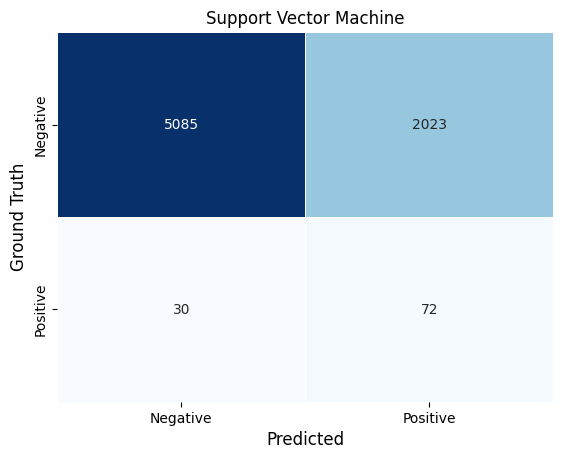

In [21]:
cm_svc = confusion_matrix(y_test,y_pred)
fig1,ax1 = plt.subplots(1)
sns.heatmap(cm_svc,
            annot = True,
            ax = ax1,
            linewidth = .5,
            fmt='g',
            cmap = 'Blues',
            cbar = False,
            xticklabels= ['Negative','Positive'],
            yticklabels= ['Negative','Positive'])

ax1.set_xlabel('Predicted', fontsize = 12) # x-axis label with fontsize 15
ax1.set_ylabel('Ground Truth', fontsize = 12) # y-axis label with fontsize 15
ax1.set_title('Support Vector Machine')

In [119]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters,scoring = 'f1')

In [120]:
clf.fit(X_train.T,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             scoring='f1')

In [122]:
y_pred = clf.predict(X_test.T)

Text(0.5, 1.0, 'Support Vector Machine')

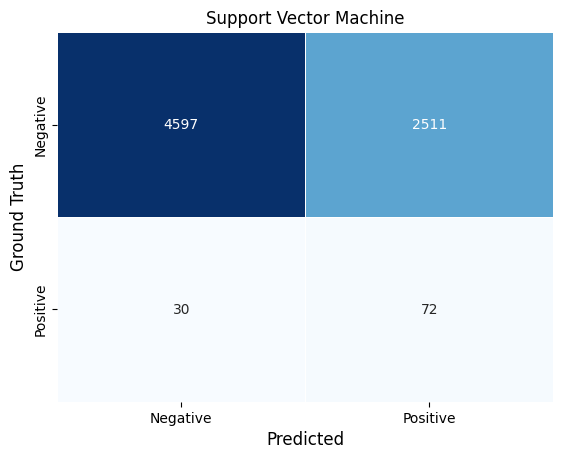

In [123]:
cm_svc = confusion_matrix(y_test,y_pred)
fig1,ax1 = plt.subplots(1)
sns.heatmap(cm_svc,
            annot = True,
            ax = ax1,
            linewidth = .5,
            fmt='g',
            cmap = 'Blues',
            cbar = False,
            xticklabels= ['Negative','Positive'],
            yticklabels= ['Negative','Positive'])

ax1.set_xlabel('Predicted', fontsize = 12) # x-axis label with fontsize 15
ax1.set_ylabel('Ground Truth', fontsize = 12) # y-axis label with fontsize 15
ax1.set_title('Support Vector Machine')

#### AdaBoost

In [38]:
#estimator = DecisionTreeClassifier(random_state = 11,criterion = 'entropy')
#estimator = svm.SVC(probability=True, kernel='linear')
model = AdaBoostClassifier(n_estimators = 50, learning_rate = 0.1)
model.fit(X_train.T,y_train)

AdaBoostClassifier(learning_rate=0.1)

In [42]:
y_pred = model.predict(X_test.T)

In [45]:
y_pred_ada = y_pred

Text(0.5, 1.0, 'AdaBoost Classifier')

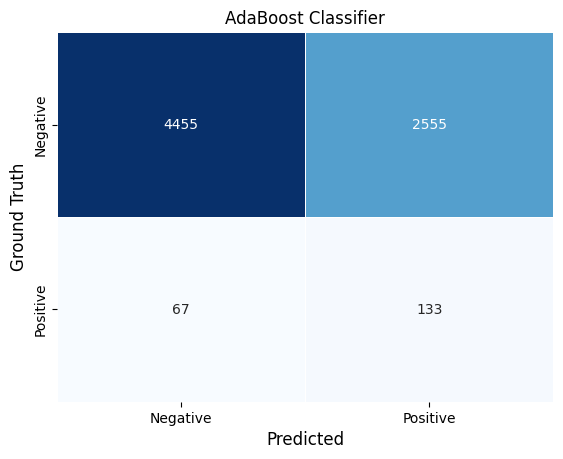

In [43]:
cm_ada = confusion_matrix(y_test,y_pred)
fig1, ax1 = plt.subplots(1)
sns.heatmap(cm_ada,
            annot = True,
            ax = ax1,
            linewidth = .5,
            fmt='g',
            cmap = 'Blues',
            cbar = False,
            xticklabels= ['Negative','Positive'],
            yticklabels= ['Negative','Positive'])

ax1.set_xlabel('Predicted', fontsize = 12) # x-axis label with fontsize 15
ax1.set_ylabel('Ground Truth', fontsize = 12) # y-axis label with fontsize 15
ax1.set_title('AdaBoost Classifier')

In [44]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.99      0.64      0.77      7010
    Positive       0.05      0.67      0.09       200

    accuracy                           0.64      7210
   macro avg       0.52      0.65      0.43      7210
weighted avg       0.96      0.64      0.75      7210



### Make Conf Mat for each of the three in one figure

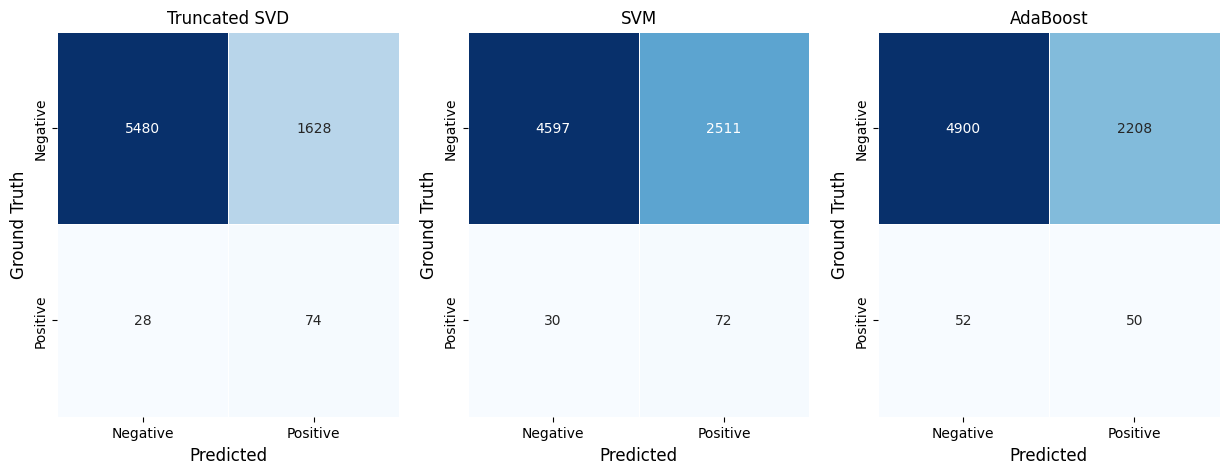

In [154]:
fig,ax = plt.subplots(1,3,figsize=(15, 5))
mats = [cm,cm_svc,cm_ada]
clf_names = ['Truncated SVD','SVM','AdaBoost']
for i in range(3):
    sns.heatmap(mats[i],
                annot = True,
                ax = ax[i],
                linewidth = .5,
                fmt='g',
                cmap = 'Blues',
                cbar = False,
                xticklabels= ['Negative','Positive'],
                yticklabels= ['Negative','Positive'])
    ax[i].set_xlabel('Predicted', fontsize = 12) # x-axis label with fontsize 15
    ax[i].set_ylabel('Ground Truth', fontsize = 12) # y-axis label with fontsize 15
    ax[i].set_title(clf_names[i])

#### Now test all of the basic classifiers on the problem
Usual stuff

In [53]:
classifiers = [
    svm.SVC(kernel='linear', C=0.01),
    svm.SVC(kernel='rbf', gamma=0.7, C=1),
    svm.SVC(kernel='poly', degree=3, C=1),
    RandomForestClassifier(n_estimators=100, random_state=0),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=5),
    KNeighborsClassifier(n_neighbors=7)
]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

SVC(C=0.01, kernel='linear')
              precision    recall  f1-score   support

    Negative       0.99      0.75      0.85      7109
    Positive       0.04      0.68      0.07       102

    accuracy                           0.75      7211
   macro avg       0.52      0.71      0.46      7211
weighted avg       0.98      0.75      0.84      7211



 11%|████▉                                       | 1/9 [02:14<17:54, 134.33s/it]

SVC(C=1, gamma=0.7)
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      7109
    Positive       0.01      1.00      0.03       102

    accuracy                           0.01      7211
   macro avg       0.01      0.50      0.01      7211
weighted avg       0.00      0.01      0.00      7211



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

SVC(C=1, kernel='poly')
              precision    recall  f1-score   support

    Negative       0.99      0.70      0.82      7109
    Positive       0.03      0.70      0.06       102

    accuracy                           0.70      7211
   macro avg       0.51      0.70      0.44      7211
weighted avg       0.98      0.70      0.81      7211



 33%|██████████████▋                             | 3/9 [08:08<15:59, 159.90s/it]

RandomForestClassifier(random_state=0)
              precision    recall  f1-score   support

    Negative       0.99      0.65      0.78      7109
    Positive       0.03      0.65      0.05       102

    accuracy                           0.65      7211
   macro avg       0.51      0.65      0.42      7211
weighted avg       0.98      0.65      0.77      7211



 44%|████████████████████                         | 4/9 [08:10<08:08, 97.69s/it]

AdaBoostClassifier(n_estimators=100, random_state=0)
              precision    recall  f1-score   support

    Negative       0.99      0.69      0.82      7109
    Positive       0.03      0.70      0.06       102

    accuracy                           0.69      7211
   macro avg       0.51      0.69      0.44      7211
weighted avg       0.98      0.69      0.81      7211



 56%|████████████████████████▍                   | 5/9 [11:28<08:55, 133.97s/it]

GaussianNB()
              precision    recall  f1-score   support

    Negative       0.99      0.54      0.70      7109
    Positive       0.02      0.68      0.04       102

    accuracy                           0.54      7211
   macro avg       0.51      0.61      0.37      7211
weighted avg       0.98      0.54      0.69      7211



 67%|█████████████████████████████▎              | 6/9 [12:03<05:00, 100.06s/it]

KNeighborsClassifier(n_neighbors=3)
              precision    recall  f1-score   support

    Negative       0.99      0.74      0.84      7109
    Positive       0.02      0.44      0.04       102

    accuracy                           0.73      7211
   macro avg       0.51      0.59      0.44      7211
weighted avg       0.98      0.73      0.83      7211



 78%|███████████████████████████████████          | 7/9 [12:12<02:20, 70.49s/it]

KNeighborsClassifier()
              precision    recall  f1-score   support

    Negative       0.99      0.74      0.84      7109
    Positive       0.03      0.47      0.05       102

    accuracy                           0.73      7211
   macro avg       0.51      0.60      0.45      7211
weighted avg       0.98      0.73      0.83      7211



 89%|████████████████████████████████████████     | 8/9 [12:21<00:50, 50.94s/it]

KNeighborsClassifier(n_neighbors=7)
              precision    recall  f1-score   support

    Negative       0.99      0.74      0.84      7109
    Positive       0.03      0.48      0.05       102

    accuracy                           0.73      7211
   macro avg       0.51      0.61      0.45      7211
weighted avg       0.98      0.73      0.83      7211



100%|█████████████████████████████████████████████| 9/9 [12:31<00:00, 83.50s/it]


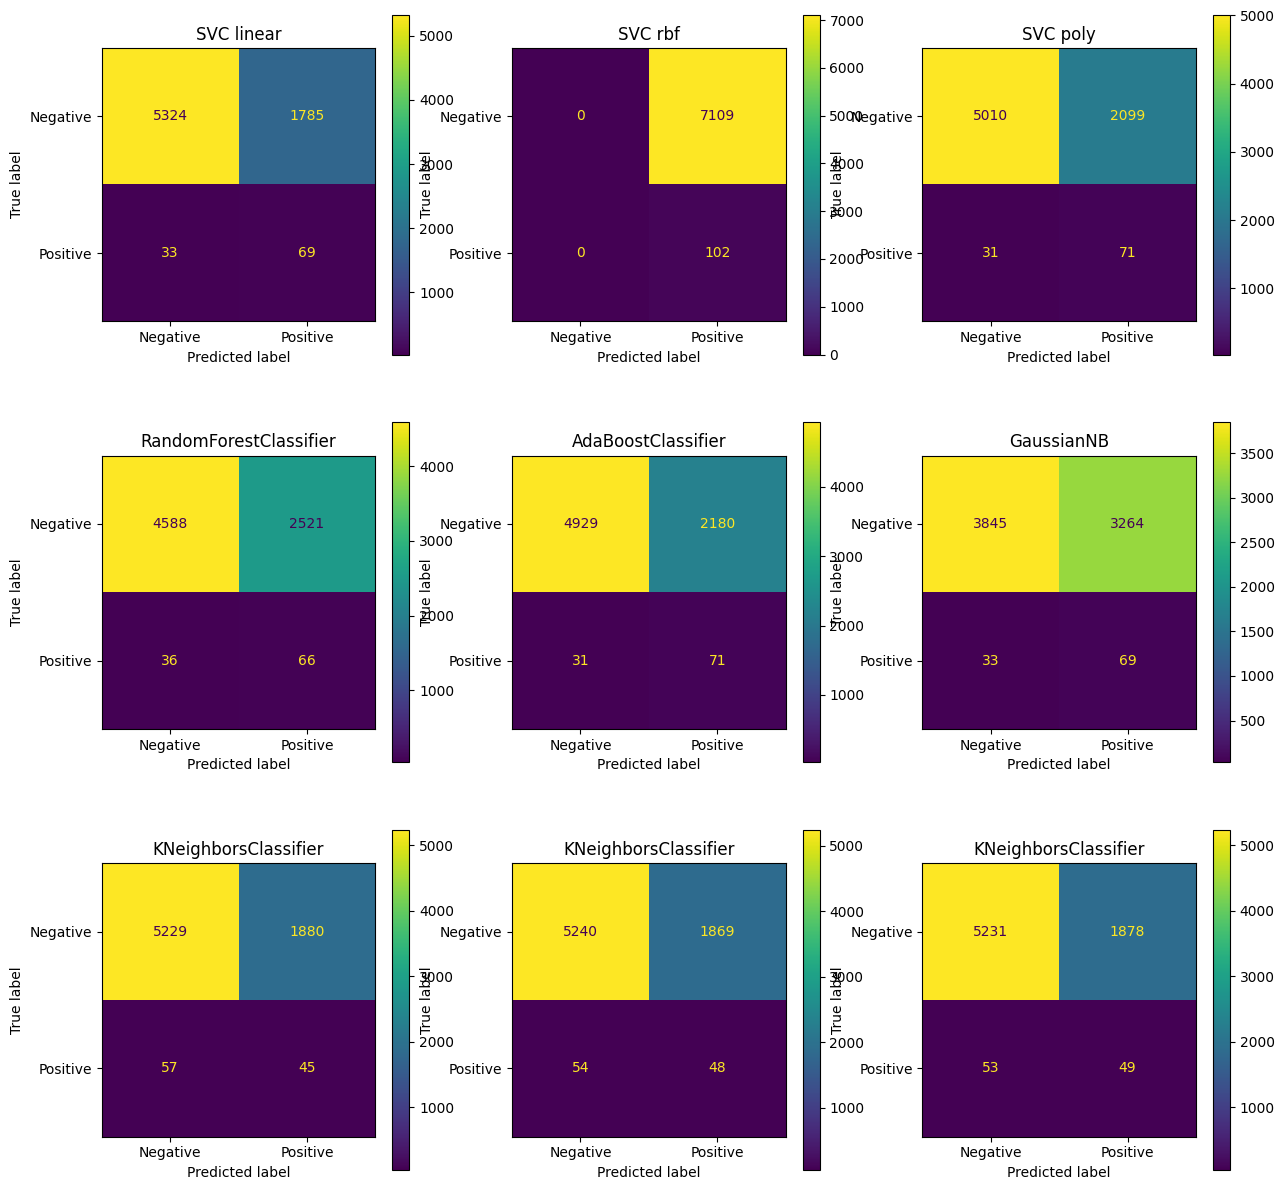

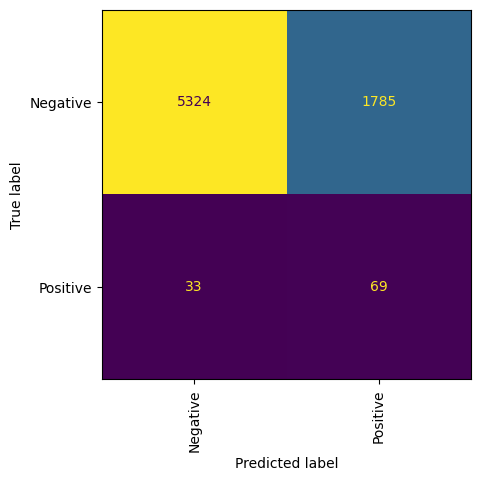

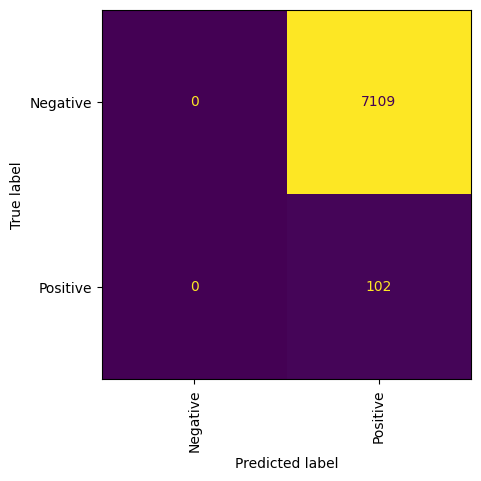

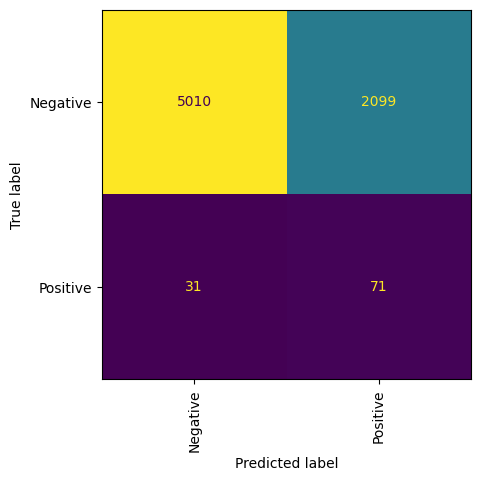

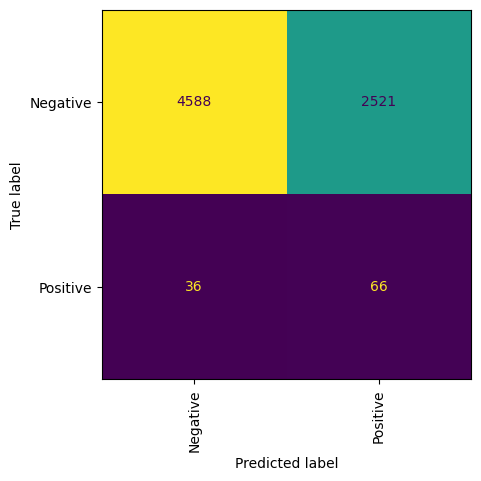

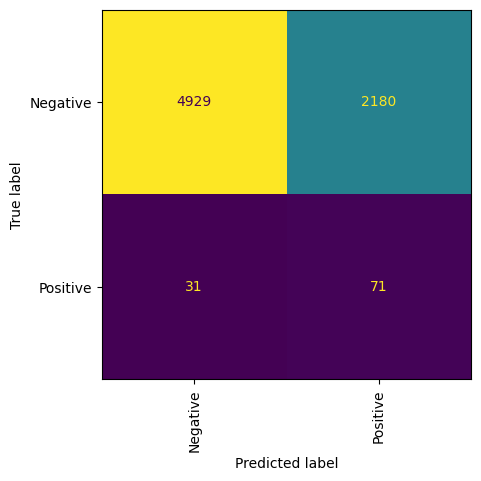

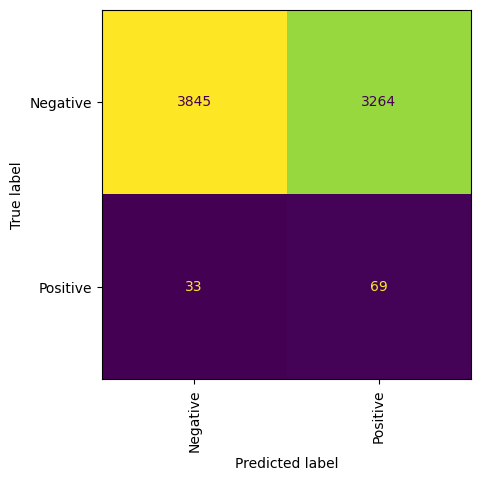

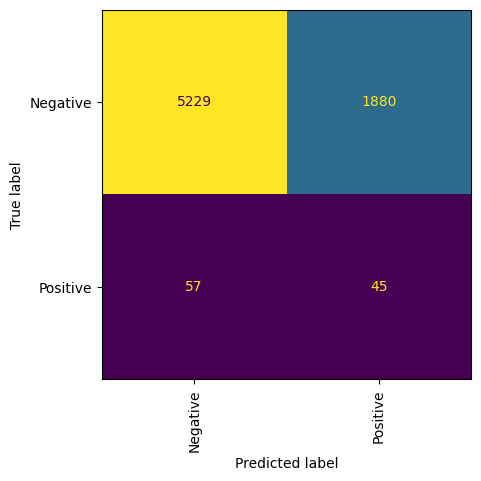

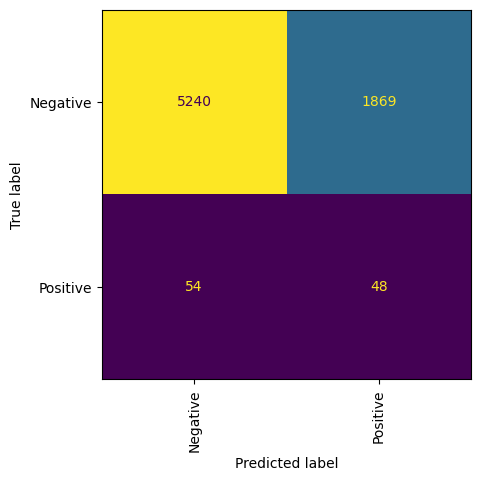

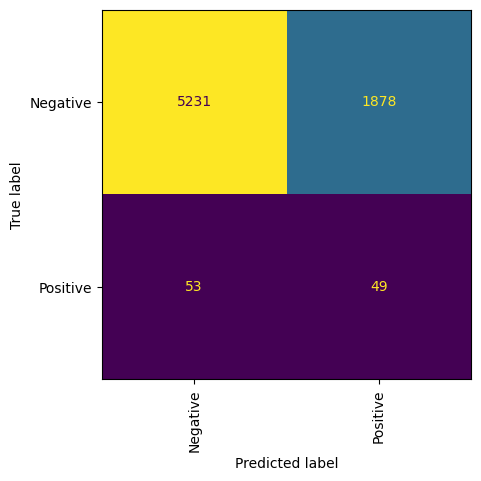

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Loop over the classifiers
for clf in tqdm(classifiers):
    clf.fit(X_train.T, y_train)
    y_pred = clf.predict(X_test.T)
    print(clf)
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    disp = ConfusionMatrixDisplay.from_estimator(
        clf, X_test.T, y_test, display_labels=['Negative', 'Positive'], xticks_rotation="vertical",colorbar=False)
    disp.plot(ax=axes.flat[classifiers.index(clf)])
    #Set title if svm add kernel
    if clf.__class__.__name__ == 'SVC':
        axes.flat[classifiers.index(clf)].set_title(clf.__class__.__name__ + ' ' + clf.kernel)
    else:
        axes.flat[classifiers.index(clf)].set_title(clf.__class__.__name__)

In [55]:
plt.tight_layout()
##Set fig title
fig.suptitle('Confusion matrix for different non DL classifiers', fontsize=16)
fig.show()

/var/folders/_r/jlncy8s12v3dnkjbml325cq00000gn/T/ipykernel_46951/625000043.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

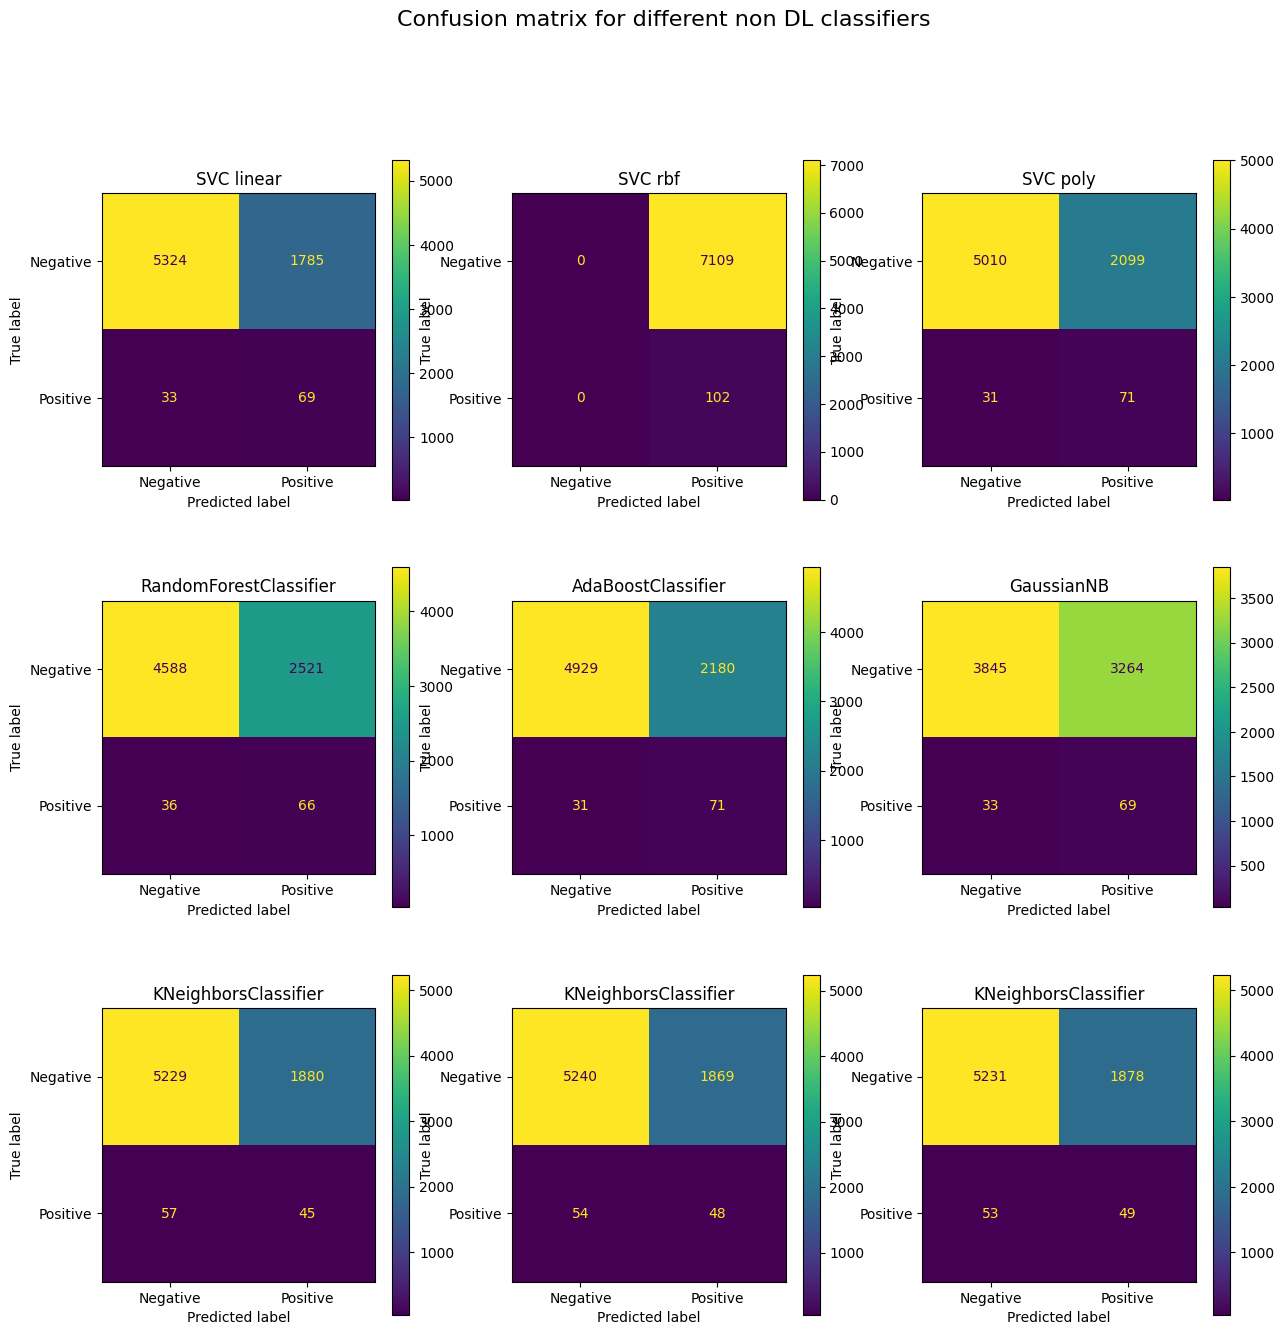

In [24]:
fig

### Making my own ensemble with the classifiers


In [ ]:
#Try with stacking classifiers
estimators = [(clf.__class__.__name__ + ' ' + clf.kernel if clf.__class__.__name__ == 'SVC' else clf.__class__.__name__, clf) for clf in classifiers[:-2]]
clf =StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train.T, y_train)
y_pred = clf.predict(X_test.T)
print(clf)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test.T, y_test, display_labels=['Negative', 'Positive'],colorbar=False
)

disp.plot()

In [ ]:
fig

In [14]:
classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

NameError: name 'y_pred' is not defined

In [32]:
import torch
from torchvision import datasets, transforms

In [34]:
trainset = datasets.MNIST('mnist_data/', download=True, train=True)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 11813201.25it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 23516927.55it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 11880545.72it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 8110059.08it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [35]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

In [38]:
for images, labels in trainset:
    break

In [40]:
type(images)

PIL.Image.Image

In [42]:
x = torch.tensor([1,2,3,4])

In [43]:
torch.argmax(x)

tensor(3)